# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [103]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
#from mlfs import config
#if os.path.exists(f"{root_dir}/.env"):
    #settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/aimao/mlfs-book


In [104]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [105]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 1, 55, 24, 95113)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [106]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-17 01:55:24,144 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 01:55:24,147 INFO: Initializing external client
2025-11-17 01:55:24,147 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 01:55:24,761 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 01:55:25,470 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272016


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [107]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=5,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 01:55:27,823 INFO: There is no parent information


Downloading: 0.000%|          | 0/509659 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/119941 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26583 elapsed<00:00 remaining<?

In [108]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.633173E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [109]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data=batch_data.sort_values('date', ascending=False)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
recent_df = air_quality_fg.filter(
    (air_quality_fg.city == city) &
    (air_quality_fg.street == street)
).read()
recent_df = recent_df.sort_values('date', ascending=False)
recent_df



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3
1800,2025-11-16 00:00:00+00:00,1.75,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.260000,2.190000,2.720000
1698,2025-11-15 00:00:00+00:00,2.26,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.190000,2.720000,2.600000
210,2025-11-14 00:00:00+00:00,2.19,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.720000,2.600000,1.100000
820,2025-11-13 00:00:00+00:00,2.72,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.600000,1.100000,0.630000
639,2025-11-12 00:00:00+00:00,2.60,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.100000,0.630000,1.540000
...,...,...,...,...,...,...,...,...,...
132,2020-03-04 00:00:00+00:00,2.22,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.410000,1.800000,5.650000
240,2020-03-03 00:00:00+00:00,2.41,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.800000,5.650000,4.500000
102,2020-03-02 00:00:00+00:00,1.80,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,5.650000,4.500000,3.508152
229,2020-03-01 00:00:00+00:00,5.65,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,4.500000,3.508152,3.508152


In [110]:
import datetime
import pandas as pd

# 初始化 lag 列
batch_data['pm25_lag1'] = 0.0
batch_data['pm25_lag2'] = 0.0
batch_data['pm25_lag3'] = 0.0
batch_data['predicted_pm25'] = 0.0



# 特征列
feature_cols = ['pm25_lag1', 'pm25_lag2', 'pm25_lag3',
                'temperature_2m_mean', 'precipitation_sum',
                'wind_speed_10m_max', 'wind_direction_10m_dominant']

# 按日期排序（确保从最早的日期开始预测）
batch_data = batch_data.sort_values('date').reset_index(drop=True)

# 获取 recent_df 的最近 3 个 PM2.5 值（作为初始 lag）
recent_pm25_list = recent_df['pm25'].tolist()






### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [111]:
for idx in range(len(batch_data)):
    # 设置 lag 特征
    if idx == 0:
        # 第一行：使用 recent_df 的历史数据
        batch_data.at[idx, 'pm25_lag1'] = recent_pm25_list[0]
        batch_data.at[idx, 'pm25_lag2'] = recent_pm25_list[1]
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[2]
    elif idx == 1:
        # 第二行：lag1 用前一行的预测值，lag2/lag3 用 recent_df
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = recent_pm25_list[0]
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[1]
    elif idx == 2:
        # 第三行：lag1/lag2 用前两行的预测值，lag3 用 recent_df
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = batch_data.at[idx-2, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag3'] = recent_pm25_list[0]
    else:
        # 后续行：全部用之前的预测值
        batch_data.at[idx, 'pm25_lag1'] = batch_data.at[idx-1, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag2'] = batch_data.at[idx-2, 'predicted_pm25']
        batch_data.at[idx, 'pm25_lag3'] = batch_data.at[idx-3, 'predicted_pm25']

    # 提取特征进行预测
    X = batch_data.iloc[[idx]][feature_cols]

    # 预测
    prediction = retrieved_xgboost_model.predict(X)
    batch_data.at[idx, 'predicted_pm25'] = prediction[0]

batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25
0,2025-11-18 00:00:00+00:00,7.55,0.0,27.952787,277.399506,Dublin,1.750000,2.260000,2.190000,1.875855
1,2025-11-19 00:00:00+00:00,4.45,0.0,23.477409,324.360107,Dublin,1.875855,1.750000,2.260000,2.026038
2,2025-11-20 00:00:00+00:00,4.60,0.0,14.386494,301.701385,Dublin,2.026038,1.875855,1.750000,2.237263
3,2025-11-21 00:00:00+00:00,8.25,0.8,29.024128,226.004990,Dublin,2.237263,2.026038,1.875855,2.080724
4,2025-11-22 00:00:00+00:00,6.30,0.0,14.039999,247.380096,Dublin,2.080724,2.237263,2.026038,3.681349


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [112]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,7.55,0.0,27.952787,277.399506,Dublin,1.750000,2.260000,2.190000,1.875855,Rathfarnham Road,Ireland,1
1,2025-11-19 00:00:00+00:00,4.45,0.0,23.477409,324.360107,Dublin,1.875855,1.750000,2.260000,2.026038,Rathfarnham Road,Ireland,2
2,2025-11-20 00:00:00+00:00,4.60,0.0,14.386494,301.701385,Dublin,2.026038,1.875855,1.750000,2.237263,Rathfarnham Road,Ireland,3
3,2025-11-21 00:00:00+00:00,8.25,0.8,29.024128,226.004990,Dublin,2.237263,2.026038,1.875855,2.080724,Rathfarnham Road,Ireland,4
4,2025-11-22 00:00:00+00:00,6.30,0.0,14.039999,247.380096,Dublin,2.080724,2.237263,2.026038,3.681349,Rathfarnham Road,Ireland,5


In [113]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   pm25_lag1                    5 non-null      float64                
 7   pm25_lag2                    5 non-null      float64                
 8   pm25_lag3                    5 non-null      float64                
 9   predicted_pm25               5 non-null      float64                
 10  street

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

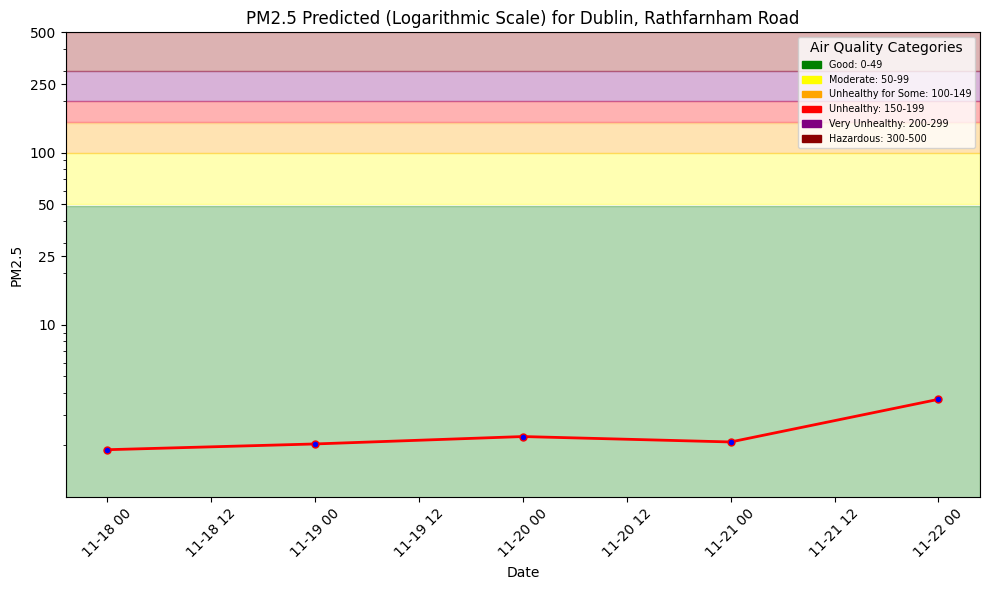

In [114]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [115]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [116]:

monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272016/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-17 01:56:10,455 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 01:56:13,628 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 01:57:54,934 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-17 01:57:58,092 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 01:57:58,245 INFO: Waiting for log aggregation to finish.
2025-11-17 01:58:20,010 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [117]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.29s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,7.55,0.0,27.952787,277.399506,Dublin,1.75,2.26,2.19,1.875855,Rathfarnham Road,Ireland,1


In [118]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df = air_quality_df.sort_values(by=['date'], ascending=True)
air_quality_df = air_quality_df.tail(10)
air_quality_df


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 


,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3
513,2025-11-07 00:00:00+00:00,1.45,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.15,1.35,0.88
334,2025-11-08 00:00:00+00:00,1.88,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.45,2.15,1.35
1632,2025-11-09 00:00:00+00:00,1.54,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.88,1.45,2.15
1383,2025-11-10 00:00:00+00:00,0.63,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.54,1.88,1.45
1072,2025-11-11 00:00:00+00:00,1.10,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,0.63,1.54,1.88
639,2025-11-12 00:00:00+00:00,2.60,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.10,0.63,1.54
820,2025-11-13 00:00:00+00:00,2.72,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.60,1.10,0.63
210,2025-11-14 00:00:00+00:00,2.19,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.72,2.60,1.10
1698,2025-11-15 00:00:00+00:00,2.26,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.19,2.72,2.60
1800,2025-11-16 00:00:00+00:00,1.75,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.26,2.19,2.72


In [119]:
features_df = weather_fg.read()
features_df = features_df.sort_values(by=['date'], ascending=True)
features_df = features_df.tail(20)
features_df
batch_hincast = pd.merge(air_quality_df, features_df, on="date")
batch_hincast
batch_hincast.info()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         10 non-null     datetime64[us, Etc/UTC]
 1   pm25                         10 non-null     float32                
 2   country                      10 non-null     object                 
 3   city_x                       10 non-null     object                 
 4   street                       10 non-null     object                 
 5   url                          10 non-null     object                 
 6   pm25_lag1                    10 non-null     float32                
 7   pm25_lag2                    10 non-null     float32                
 8   pm25_lag3                    10 non-null     float32               

In [120]:
X = batch_hincast[feature_cols]
predictions  = retrieved_xgboost_model.predict(X)
batch_hincast['predicted_pm25']=predictions
hindcast_df = batch_hincast.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,pm25,country,city_x,street,url,pm25_lag1,pm25_lag2,pm25_lag3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city_y,predicted_pm25
0,2025-11-07 00:00:00+00:00,1.45,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.15,1.35,0.88,12.643082,2.700000,17.852697,161.096603,Dublin,2.624670
1,2025-11-08 00:00:00+00:00,1.88,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.45,2.15,1.35,10.863917,0.000000,17.015474,223.829926,Dublin,2.035105
2,2025-11-09 00:00:00+00:00,1.54,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.88,1.45,2.15,12.322251,2.700000,22.500719,188.629532,Dublin,2.211258
3,2025-11-10 00:00:00+00:00,0.63,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.54,1.88,1.45,9.118084,2.000000,20.556284,222.612595,Dublin,1.939094
4,2025-11-11 00:00:00+00:00,1.10,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,0.63,1.54,1.88,11.807666,21.999998,31.602690,183.065414,Dublin,1.785403
5,2025-11-12 00:00:00+00:00,2.60,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,1.10,0.63,1.54,10.238917,16.799999,22.557526,83.592560,Dublin,3.061046
6,2025-11-13 00:00:00+00:00,2.72,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.60,1.10,0.63,11.482666,1.600000,19.361507,232.467361,Dublin,3.388234
7,2025-11-14 00:00:00+00:00,2.19,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.72,2.60,1.10,9.836834,18.599998,39.461075,71.181572,Dublin,5.709532
8,2025-11-15 00:00:00+00:00,2.26,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.19,2.72,2.60,10.218084,14.100001,38.114548,83.180397,Dublin,2.773189
9,2025-11-16 00:00:00+00:00,1.75,Ireland,Dublin,Rathfarnham Road,https://api.waqi.info/feed/A103789,2.26,2.19,2.72,8.586834,1.400000,14.747921,28.844370,Dublin,4.582924


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

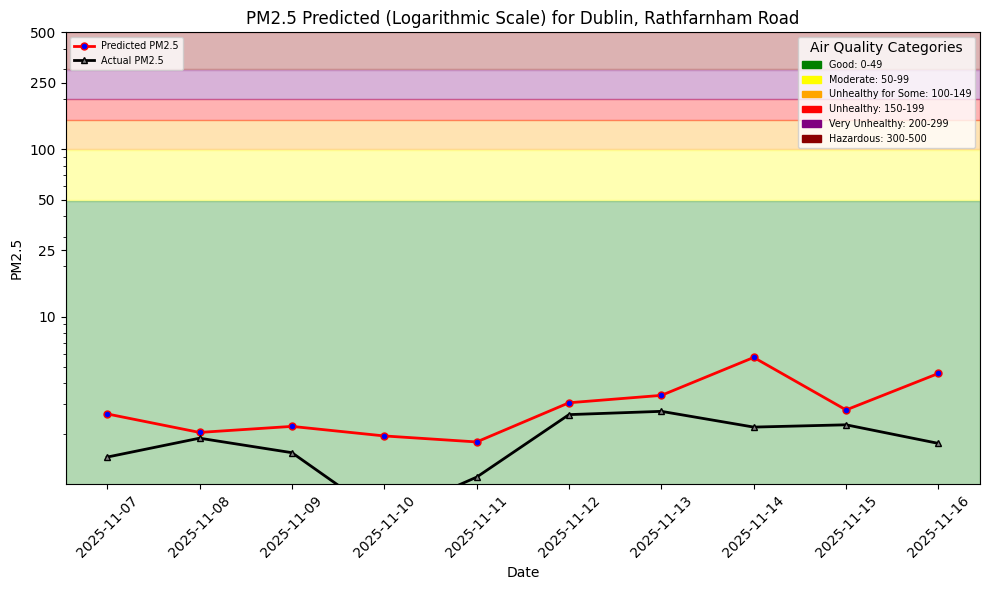

In [121]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [122]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/aimao/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/44958 elap…

Uploading /home/aimao/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | 0/60240…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272016/settings/fb/path/Resources/airquality


---